# classify_pos_and_pos+c14
    2020/11/5
    yuansc
classify 2 kinds of data using sample CNN model  
cate 1 just contains positron data  
cate 2 contains positrion and c14  

## Import libraries

In [1]:
# TensorFlow and tf.keras
#import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

## Create dataset
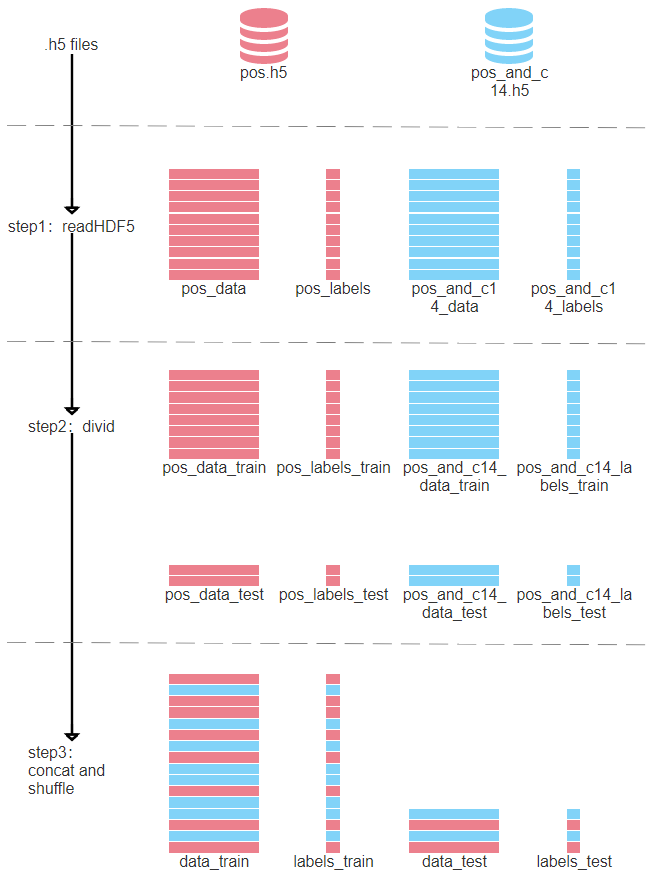

In [4]:
def readHDF5(file, key='data'):
    print('readHDF5: ', file)
    f = h5py.File(file, 'r')
    data = f[key]
    return data

def getH5Files(path, file_num=None):
    print('getH5Files: ', path)
    h5_files = [path+p for p in os.listdir(path) if '.h5' in p]
    if file_num:
        try:
            h5_files = h5_files[:file_num]
        except:
            print('getH5Files: not so much h5 files, already select all h5 files')
    return h5_files

def concatData(data_list):
    print('concatData ...')
    try:
        result = data_list[0]
    except:
        print('concatData: no data in data_list')
        return False
    for data in data_list[1:]:
        result = np.vstack((result, data))
    return result

def loadDataFromPath(path, file_num=None):
    print('loadDataFromPath: ', path, 'file_num= ', file_num)
    h5_files = getH5Files(path, file_num = file_num)
    result = concatData([readHDF5(file) for file in h5_files])
    print()
    return result

Load data  
pos:/hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/
pos_and_c14:/hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/

In [5]:
pos_path = '/hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/'
pos_and_c14_path = '/hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/'

file_num = 3

pos_data = loadDataFromPath(pos_path, file_num=file_num)
pos_labels = np.zeros((pos_data.shape[0]))

pos_and_c14_data = loadDataFromPath(pos_and_c14_path, file_num=file_num)
pos_and_c14_labels = np.ones((pos_and_c14_data.shape[0]))

print('pos_data.shape: ', pos_data.shape)
print('pos_labels.shape: ', pos_labels.shape)
print('pos_and_c14_data.shape: ', pos_and_c14_data.shape)
print('pos_and_c14_labels.shape: ', pos_and_c14_labels.shape)

loadDataFromPath:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/ file_num=  3
getH5Files:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/positron_skim_dataset_batch138_N5000.h5
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/positron_skim_dataset_batch11_N5000.h5
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos/positron_skim_dataset_batch39_N5000.h5
concatData ...

loadDataFromPath:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/ file_num=  3
getH5Files:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/positron+c14_dataset_batch29_N5000.h5
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/positron+c14_dataset_batch24_N5000.h5
readHDF5:  /hpcfs/juno/junogpu/yuansc/BackgroundRemove/dataset/pos+noi/c14/positron+c14_dataset_batch11_N

Transform 2 cate data to dataset  
train_proportion: how much data will be divided into train dataset

In [6]:
def devideTrainAndTest(data, labels, proportion=0.8):
    print('devideTrainAndTest...')
    if len(data) != len(labels):
        print('devideTrainAndTest: len(data) != len(labels)')
    index = int(data.shape[0] * proportion)
    
    data_train = data[:index]
    labels_train = labels[:index]
    data_test = data[index:]
    labels_test = labels[index:]
    
    return data_train, labels_train, data_test, labels_test

def shuffle(data, labels):
    print('shuffle data and labels...')
    state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(state)
    np.random.shuffle(labels)
    return data,labels

def addNewAxis(data, mode = 'data'):
    print('addNewAxis...')
    if mode == 'data':
        return data[:, :, :, np.newaxis]
    else:
        return data[:, np.newaxis]
    
def normolization(data):
    return data/np.max(data)
    
    

In [7]:
train_proportion = 0.8

pos_data_train, pos_labels_train, pos_data_test, pos_labels_test \
= devideTrainAndTest(pos_data, pos_labels)
pos_and_c14_data_train, pos_and_c14_labels_train, \
pos_and_c14_data_test, pos_and_c14_labels_test \
= devideTrainAndTest(pos_and_c14_data, pos_and_c14_labels)

data_train = np.vstack((pos_data_train, pos_and_c14_data_train))
labels_train = np.hstack((pos_labels_train, pos_and_c14_labels_train))
data_train, labels_train = shuffle(data_train, labels_train)
data_test = np.vstack((pos_data_test, pos_and_c14_data_test))
labels_test = np.hstack((pos_labels_test, pos_and_c14_labels_test))
data_test, labels_test = shuffle(data_test, labels_test)

data_train = addNewAxis(data_train)
labels_train = addNewAxis(labels_train, mode='labels')
labels_train = to_categorical(labels_train, num_classes=2)

data_test = addNewAxis(data_test)
labels_test = addNewAxis(labels_test, mode='labels')
labels_test = to_categorical(labels_test, num_classes=2)

print('data_train.shape: ', data_train.shape)
print('labels_train.shape: ', labels_train.shape)
print('data_test.shape: ', data_test.shape)
print('labels_test.shape: ', labels_test.shape)

devideTrainAndTest...
devideTrainAndTest...
shuffle data and labels...
shuffle data and labels...
addNewAxis...
addNewAxis...
addNewAxis...
addNewAxis...
data_train.shape:  (24000, 229, 123, 1)
labels_train.shape:  (24000, 2)
data_test.shape:  (6000, 229, 123, 1)
labels_test.shape:  (6000, 2)


Finally, The data processing is completed, our dataset contains 4 ndarraies:  
data_train, labels_train, data_test, labels_test  
## Model
2 Conv2D layers with maxpooling and dropout

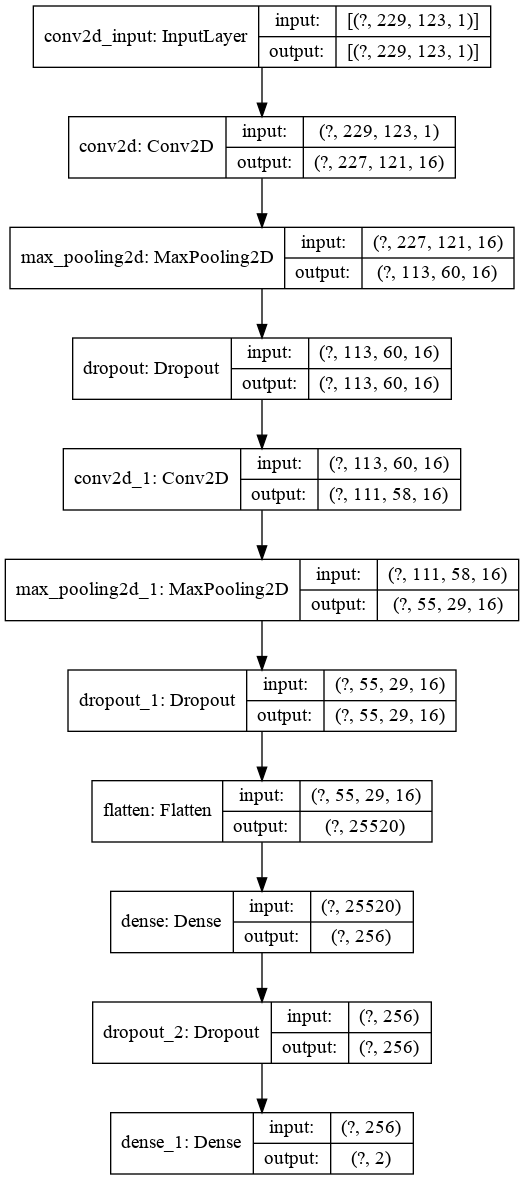

In [8]:
model = keras.Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(data_train.shape[1:])))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.01)#, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, \
             metrics=['accuracy'])

plot_model(model, to_file='modelcnn.png',show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

print('starting training...')
history = model.fit(data_train, labels_train, validation_split=0.2, \
                    batch_size=4, epochs=10, shuffle=False, \
                    callbacks=[early_stopping])
print('training complete...')

print(history.history)

score = model.evaluate(data_test, labels_test, batch_size=32)

starting training...
Epoch 1/10
4800/4800 [==============================] - 152s 32ms/step - loss: 0.6920 - accuracy: 0.5246 - val_loss: 0.6855 - val_accuracy: 0.6281
Epoch 2/10
4800/4800 [==============================] - 153s 32ms/step - loss: 0.6771 - accuracy: 0.5709 - val_loss: 0.6610 - val_accuracy: 0.5983
Epoch 3/10
4800/4800 [==============================] - 153s 32ms/step - loss: 0.6470 - accuracy: 0.6197 - val_loss: 0.6430 - val_accuracy: 0.6081
Epoch 4/10
4800/4800 [==============================] - 154s 32ms/step - loss: 0.6083 - accuracy: 0.6576 - val_loss: 0.6367 - val_accuracy: 0.6250
Epoch 5/10
2063/4800 [===========>..................] - ETA: 1:22 - loss: 0.5588 - accuracy: 0.7040